Author: Reinaldo Maciel <br>
Date: July, 22 2020

## Project Description: Twitter US Airline Sentiment

Data Description: A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from 
February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed
by categorizing negative reasons (such as "late flight" or "rude service").

### 1.Import Libraries, load dataset, print shape of data, data description

In [82]:
### importing libraries
import pandas as pd

!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet    # Stopwords, and wordnet corpus
from nltk.stem import LancasterStemmer, WordNetLemmatizer

# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/reinaldodeoliveiramaciel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/reinaldodeoliveiramaciel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/reinaldodeoliveiramaciel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [39]:
df_tweets = pd.read_csv('Tweets.csv')

In [40]:
df_tweets.shape

(14640, 15)

In [41]:
df_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [42]:
df_tweets.describe(include=['O'])

,airline_sentiment,negativereason,airline,airline_sentiment_gold,name,negativereason_gold,text,tweet_coord,tweet_created,tweet_location,user_timezone
count,14640,9178,14640,40,14640,32,14640,1019,14640,9907,9820
unique,3,10,6,3,7701,13,14427,832,14247,3081,85
top,negative,Customer Service Issue,United,negative,JetBlueNews,Customer Service Issue,@united thanks,"[0.0, 0.0]",2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)
freq,9178,2910,3822,32,63,12,6,164,5,157,3744


### Understand of data-columns: (5 Marks) <br>
a. Drop all other columns except “text” and “airline_sentiment”. <br>
b. Check the shape of data. <br>
c. Print first 5 rows of data. <br>

In [43]:
df_tweets = df_tweets[['text','airline_sentiment']]

In [44]:
df_tweets.shape

(14640, 2)

In [45]:
df_tweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


### 3. Text pre-processing: Data preparation. (20 Marks) <br>
a. Html tag removal. <br>
b. Tokenization. <br>
c. Remove the numbers. <br>
d. Removal of Special Characters and Punctuations. <br>
e. Conversion to lowercase. <br>
f. Lemmatize or stemming. <br>
g. Join the words in the list to convert back to text string in the dataframe. (So that each row
contains the data in text format.) <br>
h. Print first 5 rows of data after pre-processing. <br>

In [46]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

df_tweets['text'] = df_tweets['text'].apply(lambda x: strip_html(x))

In [47]:
def remove_numbers(text):
    txt = re.sub(r'\d+', '', text)
    return txt

df_tweets['text'] = df_tweets['text'].apply(lambda x: remove_numbers(x))

In [48]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

df_tweets['text'] = df_tweets['text'].apply(lambda x: replace_contractions(x))

In [49]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words

df_tweets['text'] = df_tweets.apply(lambda x: remove_punctuation(x))

In [52]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

df_tweets['text'] = df_tweets.apply(lambda x: remove_non_ascii(x))

In [54]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

df_tweets['text'] = df_tweets.apply(lambda x: to_lowercase(x))

In [58]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []                           # Create empty list to store pre-processed words.
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)              # Append processed words to new list.
    return lemmas

df_tweets['text'] = df_tweets.apply(lambda x: lemmatize_verbs(x))


In [60]:
df_tweets['text'] = df_tweets.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data

In [69]:
df_tweets['text'] = df_tweets['text'].apply(lambda x: ' '.join(x))

In [70]:
df_tweets.head()

,text,airline_sentiment
0,virginamerica what dhepburn said,neutral
1,virginamerica plus you have added commercials ...,positive
2,virginamerica i did not today must mean i need...,neutral
3,virginamerica it is really aggressive to blast...,negative
4,virginamerica and it is a really big bad thing...,negative


In [71]:
df_tweets_normalized = df_tweets.copy()

### 4. Vectorization: (10 Marks) <br>
a. Use CountVectorizer. <br>
b. Use TfidfVectorizer <br>

In [75]:
vectorizer = CountVectorizer(max_features=1000)
data_features_vect = vectorizer.fit_transform(df_tweets_normalized['text'])
data_features_vect = data_features_vect.toarray()  
print('Shape of count vectorizer '+ str(data_features_vect.shape))

vectorizer = TfidfVectorizer(max_features=1000)
data_features_tfidf = vectorizer.fit_transform(df_tweets_normalized['text'])
data_features_tfidf = data_features_tfidf.toarray()
print('Shape of TFIDF '+ str(data_features_tfidf.shape))

Shape of count vectorizer (14640, 1000)
Shape of TFIDF (14640, 1000)


### 5.Fit and evaluate model using both type of vectorization. (6+6 Marks)

In [79]:
labels = df_tweets_normalized['airline_sentiment']

### split for count vectorizer
X_train_vct, X_test_vct, y_train_vct, y_test_vct = train_test_split(data_features_vect, labels, test_size=0.3, random_state=42)

### split for tf idf
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(data_features_tfidf, labels, test_size=0.3, random_state=42)

In [81]:
forest_vct = RandomForestClassifier(n_estimators=20, n_jobs=4)
forest_vct = forest_vct.fit(X_train_vct, y_train_vct)

forest_tfidf = RandomForestClassifier(n_estimators=20, n_jobs=4)
forest_tfidf = forest_tfidf.fit(X_train_tfidf, y_train_tfidf)


print('Score for vectorizer: ', np.mean(cross_val_score(forest_vct, data_features_vect, labels, cv=10)))
print('Score for tfidf:', np.mean(cross_val_score(forest_tfidf, data_features_tfidf, labels, cv=10)))

Score for vectorizer:  0.7217896174863387
Score for tfidf: 0.7243852459016392


In [83]:
result_vct = forest_vct.predict(X_test_vct)
result_tfidf = forest_tfidf.predict(X_test_tfidf)

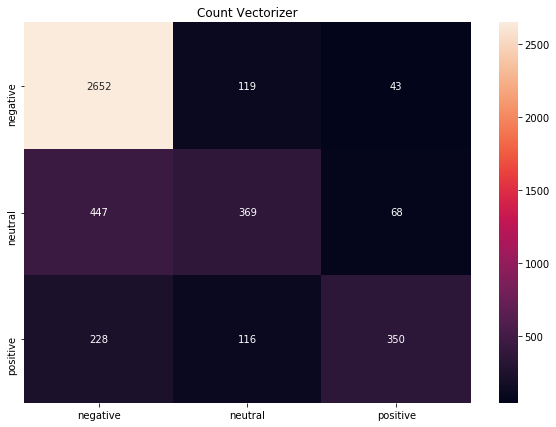

In [91]:
conf_mat = confusion_matrix(y_test_vct, result_vct)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['negative','neutral','positive']],
                  columns = [i for i in ['negative','neutral','positive']])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, fmt='g').set_title('Count Vectorizer')

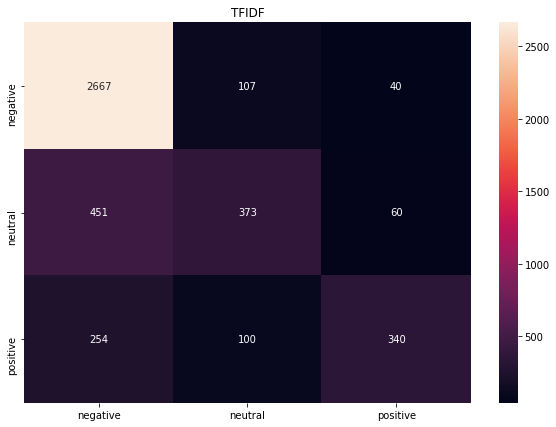

In [92]:
conf_mat = confusion_matrix(y_test_tfidf, result_tfidf)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['negative','neutral','positive']],
                  columns = [i for i in ['negative','neutral','positive']])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, fmt='g').set_title('TFIDF')

### 6. Summarize your understanding of the application of Various Pre-processing and Vectorization and performance of your model on this dataset. (8 Marks)

The entire process of data normalization for text classification have steps such as tokenization, remove punctuation, numbers, special characters, convert to lowercase all of this with the goal to have text data that are more like to emphazise what is different between the tweets.

Both vectorization and tfidf are different ways to count the words and convert the features for models and we can see that on the same data they have similar performance.
    